<a href="https://colab.research.google.com/github/vicmcl/ml-laptime/blob/main/ml_laptime/notebook/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
from pathlib import Path
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
# Mount Drive
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "laptime-simulation"

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
data_path = glob.glob(str(ML_PATH / "races_*.pkl"))

In [4]:
pip install -q fastf1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.3/148.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00


In [ ]:
data_path

['/content/drive/MyDrive/Projects/laptime-simulation/races_2021.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2020.pkl',
 '/content/drive/MyDrive/Projects/laptime-simulation/races_2019.pkl']

In [117]:
data = {}
with open(data_path[0], "rb") as f:
    data[2021] = pickle.load(f)

with open(data_path[1], "rb") as f:
    data[2020] = pickle.load(f)

with open(data_path[2], "rb") as f:
    data[2019] = pickle.load(f)

In [125]:
gp_list = data[2021].keys() & data[2020].keys() & data[2019].keys()
gp_list

{'Abu Dhabi Grand Prix',
 'Austrian Grand Prix',
 'Bahrain Grand Prix',
 'Belgian Grand Prix',
 'Hungarian Grand Prix',
 'Russian Grand Prix',
 'Spanish Grand Prix'}

In [6]:
columns_laps = [
    'Time', 'LapNumber', 'Stint', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
    'Compound', 'TyreLife', 'LapTime'
]

columns_telemetry = ['SessionTime', 'Throttle', 'Brake', 'DRS']

columns_weather = ['Time', 'TrackTemp', 'WindSpeed']

compound_map = {
    'SOFT': 1.0,
    'MEDIUM': 2.0,
    'HARD': 3.0
}

In [7]:
def process_lap_data(gp, year):
    laps_data = data[year][gp]['laps'][columns_laps].copy()
    laps_data['Season'] = year
    laps_data = laps_data.reset_index().drop('index', axis=1)
    laps_data['Compound'] = laps_data['Compound'].map(lambda x: compound_map.get(x, 0.0))
    return laps_data

In [8]:
def map_drs(drs):
    if drs >= 10:
        return True
    else:
        return False

def process_telemetry_data(gp, year, laps):
    telemetry_data = data[year][gp]['telemetry'][columns_telemetry].copy()
    telemetry_with_laps = pd.merge_asof(
        telemetry_data,
        laps[['Time', 'LapNumber']],
        left_on='SessionTime',
        right_on='Time',
        direction='forward'
    ).drop('Time', axis=1)
    telemetry_with_laps.loc[:, 'DRS'] = telemetry_with_laps['DRS'].map(map_drs)
    telemetry_avg = telemetry_with_laps.groupby('LapNumber').mean()
    return telemetry_avg

In [9]:
def process_weather_data(gp, year):
    weather_data = data[year][gp]['weather'][columns_weather].copy()
    return weather_data

In [10]:
def merge_data(laps, weather, telemetry):
    merged_data = pd.merge_asof(laps, weather, on='Time', direction='nearest').set_index('LapNumber').drop('Time', axis=1)
    merged_data = pd.concat([merged_data, telemetry], axis=1).reset_index()
    merged_data = merged_data.drop('SessionTime', axis=1)
    merged_data.loc[:, 'LapTime'] = merged_data['LapTime'].map(lambda x: x.total_seconds())
    return merged_data

In [11]:
def preprocess_data(gp, year):
    laps = process_lap_data(gp, year)
    weather = process_weather_data(gp, year)
    telemetry = process_telemetry_data(gp, year, laps)
    merged_data = merge_data(laps, weather, telemetry)
    return merged_data

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

si = SimpleImputer()

In [184]:
gp = 'Austrian Grand Prix'
df = pd.DataFrame()

for year in sorted(list(data.keys())):
    prepro_data = preprocess_data(gp, year)
    for col in prepro_data.columns:
        prepro_data[col] = si.fit_transform(prepro_data[[col]])
    df = pd.concat([df, prepro_data])

df = df.reset_index(drop=True)
df = df.dropna(subset='LapTime')

df['LagLapTime'] = df['LapTime'].shift(1)
df['RollingMeanLapTime'] = df['LapTime'].rolling(window=5).mean()

In [185]:
df.info()

<class 'fastf1.core.Laps'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LapNumber           152 non-null    float64
 1   Stint               152 non-null    float64
 2   SpeedI1             152 non-null    float64
 3   SpeedI2             152 non-null    float64
 4   SpeedFL             152 non-null    float64
 5   SpeedST             152 non-null    float64
 6   Compound            152 non-null    float64
 7   TyreLife            152 non-null    float64
 8   LapTime             152 non-null    float64
 9   Season              152 non-null    float64
 10  TrackTemp           152 non-null    float64
 11  WindSpeed           152 non-null    float64
 12  Throttle            152 non-null    float64
 13  Brake               152 non-null    float64
 14  DRS                 152 non-null    float64
 15  LagLapTime          151 non-null    float64
 16  RollingMeanLapTime 

In [186]:
df.head()

,LapNumber,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Compound,TyreLife,LapTime,Season,TrackTemp,WindSpeed,Throttle,Brake,DRS,LagLapTime,RollingMeanLapTime
0,1.0,1.0,312.0,225.0,274.0,314.0,2.0,4.0,69.217043,2019.0,51.4,1.8,64.302405,0.207904,0.000000,NaN,NaN
1,2.0,1.0,297.0,226.0,272.0,292.0,2.0,5.0,71.495000,2019.0,51.0,1.8,67.629151,0.178967,0.000000,69.217043,NaN
2,3.0,1.0,316.0,229.0,278.0,310.0,2.0,6.0,70.999000,2019.0,51.3,0.8,66.247672,0.191806,0.255121,71.495000,NaN
3,4.0,1.0,309.0,220.0,277.0,303.0,2.0,7.0,71.100000,2019.0,51.2,1.2,64.897388,0.212687,0.292910,70.999000,NaN
4,5.0,1.0,325.0,228.0,280.0,309.0,2.0,8.0,70.839000,2019.0,51.4,0.7,67.654784,0.210131,0.305816,71.100000,70.730009


In [187]:
df_train, df_test = df.iloc[:-20], df.iloc[-20:]

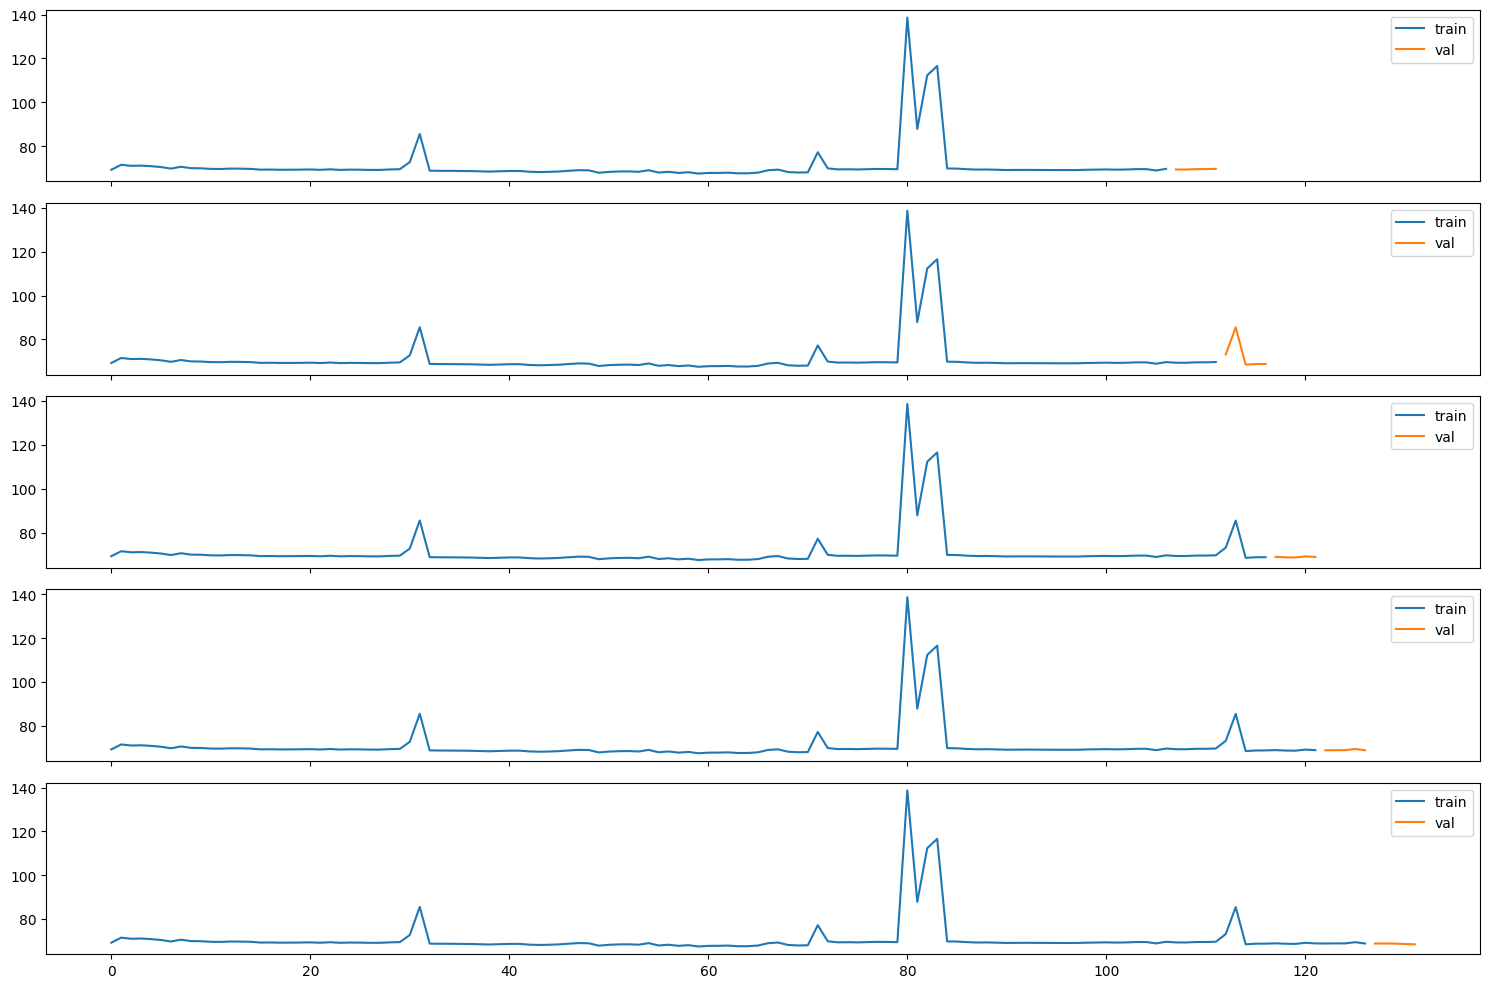

In [188]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=5)

fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df_train):
    train = df_train.loc[train_idx]
    val = df_train.loc[val_idx]
    train['LapTime'].plot(ax=axs[fold], label='train')
    val['LapTime'].plot(ax=axs[fold], label='val')
    axs[fold].legend()
    fold += 1
plt.tight_layout()
plt.show()

In [91]:
def select_speed_trap(data):
    corr = data[['LapTime', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']].corr()
    speed_trap = corr['LapTime'].iloc[1:].abs().idxmax()
    return speed_trap

def filter_speed_trap(data, speed_trap):
    data = data.drop([speed for speed in ['SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST'] if speed != speed_trap], axis=1)
    data = data.rename(columns={speed_trap: 'SpeedTrap'})
    return data

In [189]:
for train_idx, val_idx in tss.split(df_train):
    break

speed_trap = select_speed_trap(df_train.loc[train_idx])

df_train = filter_speed_trap(df_train, speed_trap)
df_test = filter_speed_trap(df_test, speed_trap)

In [192]:
FEATURES = list(df_train.columns)
FEATURES.remove('LapTime')
TARGET = 'LapTime'

In [193]:
FEATURES

['LapNumber',
 'Stint',
 'SpeedTrap',
 'Compound',
 'TyreLife',
 'Season',
 'TrackTemp',
 'WindSpeed',
 'Throttle',
 'Brake',
 'DRS',
 'LagLapTime',
 'RollingMeanLapTime']

In [195]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

preds = []
scores = []

for train_idx, val_idx in tss.split(df_train):
    X_train, y_train = df_train.loc[train_idx, FEATURES], df_train.loc[train_idx, TARGET]
    X_val, y_val = df_train.loc[val_idx, FEATURES], df_train.loc[val_idx, TARGET]

    model = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        early_stopping_rounds=50,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100
    )

    y_pred = model.predict(X_val)
    preds.append(y_pred)
    score = mean_squared_error(y_val, y_pred, squared=False)
    scores.append(score)

[0]	validation_0-rmse:9.00308	validation_1-rmse:1.46738
[100]	validation_0-rmse:0.56272	validation_1-rmse:0.15554
[105]	validation_0-rmse:0.49735	validation_1-rmse:0.15220
[0]	validation_0-rmse:8.80535	validation_1-rmse:6.57689
[100]	validation_0-rmse:0.55137	validation_1-rmse:1.41931
[200]	validation_0-rmse:0.06785	validation_1-rmse:1.32228
[300]	validation_0-rmse:0.02091	validation_1-rmse:1.30195
[400]	validation_0-rmse:0.00573	validation_1-rmse:1.29965
[419]	validation_0-rmse:0.00480	validation_1-rmse:1.30024
[0]	validation_0-rmse:8.71817	validation_1-rmse:2.06564
[100]	validation_0-rmse:0.53597	validation_1-rmse:0.89359
[200]	validation_0-rmse:0.06635	validation_1-rmse:0.86574
[300]	validation_0-rmse:0.02139	validation_1-rmse:0.86277
[0]	validation_0-rmse:8.54781	validation_1-rmse:1.91456
[88]	validation_0-rmse:0.70856	validation_1-rmse:1.41749
[0]	validation_0-rmse:8.38614	validation_1-rmse:2.06520
[100]	validation_0-rmse:0.51665	validation_1-rmse:0.34530
[177]	validation_0-rmse:0